# GANs - MNIST (keras)

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('TensorFlow Version: {}'.format(tf.__version__))

Found GPU at: /device:GPU:0
TensorFlow Version: 1.14.0


In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18419747342420030152
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5383033122920160415
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11829134396451768415
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2496842594148257991
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
import keras.backend as K
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


## Imports

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def save_images(images, it, img_rows=28, img_cols=28):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        ax.imshow(img.reshape(img_rows, img_cols))
    
    fig.savefig("plots/image_iter_{}.png".format(it))
    plt.close(fig)
    

def show_images(images, img_rows=28, img_cols=28):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape(img_rows, img_cols))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten,  Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Conv2DTranspose, LeakyReLU
# from keras.layers import Dropout, UpSampling2D, ZeroPadding2D
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [0]:
def load_mnist_data(dim):
    from keras.datasets import mnist
    from keras import backend as K
    from keras.utils import to_categorical
    img_rows = 28
    img_cols = 28
    num_classes = 10
    
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    print(len(X_train), 'train samples')
    print(len(X_test), 'test samples')
    
    if dim == 3:
        if K.image_data_format() == 'channels_first':
            X_train = X_train.reshape(len(X_train), 1, img_rows, img_cols)
            X_test = X_test.reshape(len(X_test), 1, img_rows, img_cols)
        else:
            X_train = X_train.reshape(len(X_train), img_rows, img_cols, 1)
            X_test = X_test.reshape(len(X_test), img_rows, img_cols, 1)
    elif dim == 1:
        X_train = X_train.reshape(len(X_train), -1)
        X_test = X_test.reshape(len(X_test), -1)

    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)

    # convert class vectors to binary class matrices
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    return (X_train, y_train), (X_test, y_test)


(X_train, y_train), (X_test, y_test) = load_mnist_data(dim=3)

11493376/11490434 [==============================] - 0s 0us/step
60000 train samples
10000 test samples
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


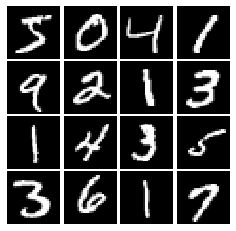

In [0]:
# show sample images
show_images(X_train[:16])

In [0]:
class dataset_batches():
    def __init__(self, X_train, shuffle=True):
        self.X_train = preprocess_img(X_train)
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        n = len(self.X_train)
        if self.shuffle:
            idx = np.arange(n)
            np.random.shuffle(idx)
            self.X_train = self.X_train[idx]
            
        n_batches = n // batch_size
        for i in range(0, n_batches * batch_size, batch_size):
            yield self.X_train[i:i+batch_size]

## DCGAN

In [0]:
def build_discriminator():
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(32, kernel_size=5, padding="valid")(inputs)
    x = LeakyReLU(0.01)(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
    x = Conv2D(64, kernel_size=5, padding="valid")(x)
    x = LeakyReLU(0.01)(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding="same")(x)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.01)(x)
    probs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, probs)
    return model
# build_discriminator()  # 1102721

def build_generator(noise_dim):
    inputs = Input(shape=(noise_dim, ))
    x = Dense(1024, activation="relu")(inputs)
    x = BatchNormalization()(x, training=True)
    x = Dense(7*7*128, activation="relu")(x)
    x = BatchNormalization()(x, training=True)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(64, kernel_size=4, strides=2, activation="relu", padding="same")(x)
    x = BatchNormalization()(x, training=True)
    img = Conv2DTranspose(1, kernel_size=4, strides=2, activation="tanh", padding="same")(x)
    
    model = Model(inputs, img)
    return model
# build_generator(4)  # 6595521

In [0]:
def gan_loss(imgs, gen_imgs, z):
    """Compute the GAN loss.

    Returns:
    - d_loss: discriminator loss scalar
    - g_loss: generator loss scalar
    """
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    # Train Discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train Generator (wants discriminator to mistake images as real)
    g_loss = combined.train_on_batch(z, valid)
    return d_loss, g_loss

def train(X_train, batch_size=128, epochs=10, show_every=250, print_every=50):
    it = 0
    for epoch in range(epochs):
        for imgs in dataset_batches(X_train).batches(batch_size):
            
            # Sample noise and generate a batch of new images
            z = np.random.uniform(-1, 1, (batch_size, noise_dim))
            gen_imgs = generator.predict(z)
                
            # every show often, show a sample result
            if it % show_every == 0:
                show_images(gen_imgs[:16])

            # Train Discriminator & Generator
            d_loss, g_loss = gan_loss(imgs, gen_imgs, z)

            # print loss every so often.
            # We want to make sure D_loss doesn't go to 0
            if it % print_every == 0:
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(it, d_loss[0], g_loss))
                
            it += 1
            
    print('Final images')
    show_images(gen_imgs[:16])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




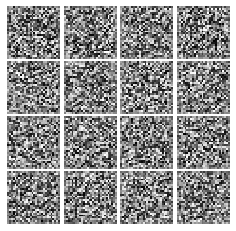

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Iter: 0, D: 0.7904, G:0.5923


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Iter: 50, D: 0.3116, G:3.662
Iter: 100, D: 0.4195, G:2.748
Iter: 150, D: 0.4361, G:2.35
Iter: 200, D: 0.4547, G:2.231


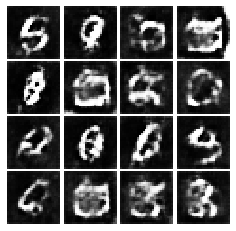

Iter: 250, D: 0.4596, G:1.87
Iter: 300, D: 0.5144, G:1.684
Iter: 350, D: 0.5911, G:1.479
Iter: 400, D: 0.5912, G:1.253
Iter: 450, D: 0.6415, G:1.116


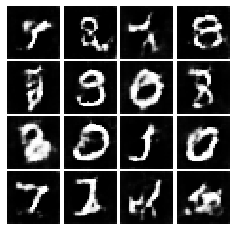

Iter: 500, D: 0.588, G:1.128
Iter: 550, D: 0.6545, G:1.036
Iter: 600, D: 0.6293, G:0.9939
Iter: 650, D: 0.637, G:0.993
Iter: 700, D: 0.5956, G:1.003


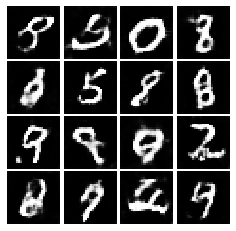

Iter: 750, D: 0.5987, G:0.9966
Iter: 800, D: 0.6087, G:0.9709
Iter: 850, D: 0.6138, G:1.001
Iter: 900, D: 0.6354, G:0.9332
Iter: 950, D: 0.6605, G:0.9472


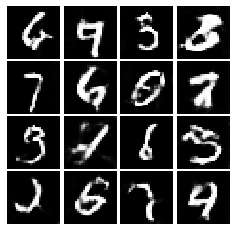

Iter: 1000, D: 0.6318, G:0.9646
Iter: 1050, D: 0.6354, G:0.9298
Iter: 1100, D: 0.6347, G:0.9356
Iter: 1150, D: 0.6329, G:0.9588
Iter: 1200, D: 0.613, G:0.8975


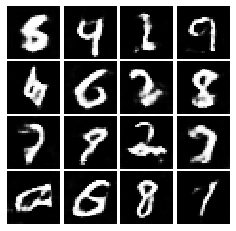

Iter: 1250, D: 0.6322, G:0.8987
Iter: 1300, D: 0.6189, G:0.9425
Iter: 1350, D: 0.6453, G:0.9001
Iter: 1400, D: 0.629, G:0.9151
Iter: 1450, D: 0.6071, G:0.9349


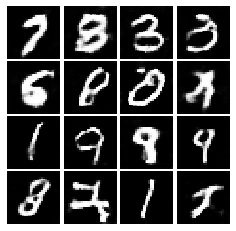

Iter: 1500, D: 0.634, G:0.8937
Iter: 1550, D: 0.6446, G:0.9021
Iter: 1600, D: 0.6561, G:0.8804
Iter: 1650, D: 0.6381, G:0.9149
Iter: 1700, D: 0.6307, G:0.928


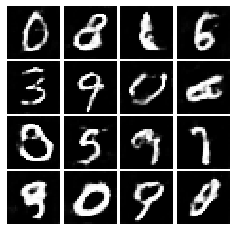

Iter: 1750, D: 0.6263, G:0.9546
Iter: 1800, D: 0.6115, G:0.9084
Iter: 1850, D: 0.6587, G:0.8897
Iter: 1900, D: 0.645, G:0.8769
Iter: 1950, D: 0.6461, G:0.8659


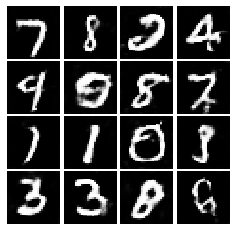

Iter: 2000, D: 0.6283, G:0.8957
Iter: 2050, D: 0.6668, G:0.8637
Iter: 2100, D: 0.6355, G:0.8722
Iter: 2150, D: 0.6452, G:0.883
Iter: 2200, D: 0.6528, G:0.8782


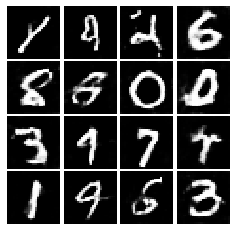

Iter: 2250, D: 0.6465, G:0.8777
Iter: 2300, D: 0.632, G:0.9193
Final images


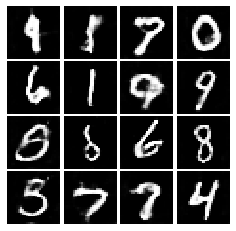

In [0]:
batch_size = 128
epochs = 5
noise_dim = 96

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
n_disc_trainable = len(discriminator.trainable_weights)

# Build the generator
generator = build_generator(noise_dim)
n_gen_trainable = len(generator.trainable_weights)

# The generator takes noise as input and generates imgs
gen_inputs = Input(shape=(noise_dim, ))
img = generator(gen_inputs)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(gen_inputs, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
assert len(discriminator._collected_trainable_weights) == n_disc_trainable
assert len(combined._collected_trainable_weights) == n_gen_trainable

train(X_train, batch_size=batch_size, epochs=epochs)

In [0]:
# class DCGAN():
#     def __init__(self):
#         # Input shape
#         self.img_rows = 28
#         self.img_cols = 28
#         self.channels = 1
#         self.img_shape = (self.img_rows, self.img_cols, self.channels)
#         self.latent_dim = 100

#         optimizer = Adam(0.0002, 0.5)

#         # Build and compile the discriminator
#         self.discriminator = self.build_discriminator()
#         self.discriminator.compile(
#             loss='binary_crossentropy',
#             optimizer=optimizer,
#             metrics=['accuracy'])
#         n_disc_trainable = len(self.discriminator.trainable_weights)
        
#         # Build the generator
#         self.generator = self.build_generator()
#         n_gen_trainable = len(self.generator.trainable_weights)
        
#         # The generator takes noise as input and generates imgs
#         z = Input(shape=(100,))
#         img = self.generator(z)

#         # For the combined model we will only train the generator
#         self.discriminator.trainable = False

#         # The discriminator takes generated images as input and determines validity
#         valid = self.discriminator(img)

#         # The combined model  (stacked generator and discriminator)
#         # Trains the generator to fool the discriminator
#         self.combined = Model(z, valid)
#         self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
#         assert len(self.discriminator._collected_trainable_weights) == n_disc_trainable
#         assert len(self.combined._collected_trainable_weights) == n_gen_trainable

#     def build_generator(self):

#         model = Sequential()

#         model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
#         model.add(Reshape((7, 7, 128)))
#         model.add(UpSampling2D())
#         model.add(Conv2D(128, kernel_size=3, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
#         model.add(Conv2D(64, kernel_size=3, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
#         model.add(Activation("tanh"))

#         print(model.summary())

#         noise = Input(shape=(self.latent_dim,))
#         img = model(noise)

#         return Model(noise, img)

#     def build_discriminator(self):

#         model = Sequential()

#         model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
#         model.add(ZeroPadding2D(padding=((0,1),(0,1))))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Flatten())
#         model.add(Dense(1, activation='sigmoid'))

#         print(model.summary())

#         img = Input(shape=self.img_shape)
#         validity = model(img)

#         return Model(img, validity)

#     def train(self, epochs, batch_size=128, sample_interval=100):

#         # Load the dataset
#         (X_train, _), (_, _) = load_mnist_data(dim=3)

#         # Rescale -1 to 1
#         X_train = rescale_image(X_train, True) #         X_train = X_train / 127.5 - 1.

#         # Adversarial ground truths
#         valid = np.ones((batch_size, 1))
#         fake = np.zeros((batch_size, 1))

#         for epoch in range(epochs):

#             # ---------------------
#             #  Train Discriminator
#             # ---------------------

#             # Select a random half of images
#             idx = np.random.randint(0, X_train.shape[0], batch_size)
#             imgs = X_train[idx]

#             # Sample noise and generate a batch of new images
#             noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
#             gen_imgs = self.generator.predict(noise)

#             # Train the discriminator (real classified as ones and generated as zeros)
#             d_loss_real = self.discriminator.train_on_batch(imgs, valid)
#             d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
#             d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#             # ---------------------
#             #  Train Generator
#             # ---------------------

#             # Train the generator (wants discriminator to mistake images as real)
#             g_loss = self.combined.train_on_batch(noise, valid)

#             # If at sample_interval => sample generated image samples
#             if epoch % sample_interval == 0:
#                 # Print the progress
#                 print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
#                 self.sample_imgs(epoch)

#     def sample_imgs(self, epoch):
#         r, c = 5, 5
#         noise = np.random.normal(0, 1, (r * c, self.latent_dim))
#         gen_imgs = self.generator.predict(noise)

#         # Rescale images 0 - 1
#         gen_imgs = rescale_image(gen_imgs, False) #         gen_imgs = 0.5 * gen_imgs + 0.5

#         fig, axs = plt.subplots(r, c)
#         cnt = 0
#         for i in range(r):
#             for j in range(c):
#                 axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
#                 axs[i,j].axis('off')
#                 cnt += 1
#         #fig.savefig("images/mnist_%d.png" % epoch)
#         #plt.close()
#         plt.show()


# dcgan = DCGAN()
# dcgan.train(epochs=4000, batch_size=32, sample_interval=50)

In [0]:
# Save n_disc_trainable = len(discriminator.trainable_weights) after step 1 from above and make sure len(discriminator._collected_trainable_weights) == n_disc_trainable after step 4 from above.
# Save n_gen_trainable = len(generator.trainable_weights) after step 2 from above and make sure len(combined._collected_trainable_weights) == n_gen_trainable after step 4 from above.

## DCGAN with LSGAN loss

In [0]:
def lsgan_loss(imgs, gen_imgs, z):
    """Compute the GAN loss.

    Returns:
    - d_loss: discriminator loss scalar
    - g_loss: generator loss scalar
    """
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    # Train Discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train Generator (wants discriminator to mistake images as real)
    g_loss = combined.train_on_batch(z, valid)
    return d_loss, g_loss

def train(X_train, batch_size=128, epochs=10, show_every=250, print_every=50):
    it = 0
    for epoch in range(epochs):
        for imgs in dataset_batches(X_train).batches(batch_size):
            
            # Sample noise and generate a batch of new images
            z = np.random.uniform(-1, 1, (batch_size, noise_dim))
            gen_imgs = generator.predict(z)
                
            # every show often, show a sample result
            if it % show_every == 0:
                fig = show_images(gen_imgs[:16])
                plt.show()

            # Train Discriminator & Generator
            d_loss, g_loss = lsgan_loss(imgs, gen_imgs, z)

            # print loss every so often.
            # We want to make sure D_loss doesn't go to 0
            if it % print_every == 0:
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(it, d_loss[0], g_loss))
                
            it += 1
            
    print('Final images')
    fig = show_images(gen_imgs[:16])
    plt.show()

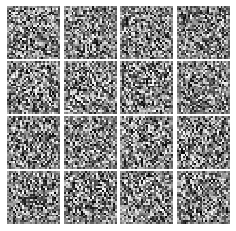

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Iter: 0, D: 0.5639, G:0.1175
Iter: 50, D: 0.2158, G:0.3785
Iter: 100, D: 0.2063, G:0.4186
Iter: 150, D: 0.2261, G:0.3682
Iter: 200, D: 0.222, G:0.3688


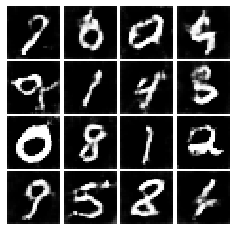

Iter: 250, D: 0.2223, G:0.3628
Iter: 300, D: 0.2121, G:0.382
Iter: 350, D: 0.2303, G:0.3493
Iter: 400, D: 0.23, G:0.3579
Iter: 450, D: 0.2219, G:0.3478


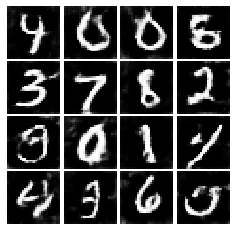

Iter: 500, D: 0.2265, G:0.3566
Iter: 550, D: 0.221, G:0.3693
Iter: 600, D: 0.2144, G:0.3589
Iter: 650, D: 0.221, G:0.3768
Iter: 700, D: 0.2191, G:0.3543


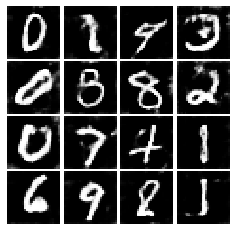

Iter: 750, D: 0.2413, G:0.3546
Iter: 800, D: 0.2315, G:0.3688
Iter: 850, D: 0.2114, G:0.3637
Iter: 900, D: 0.2026, G:0.388
Iter: 950, D: 0.2035, G:0.3873


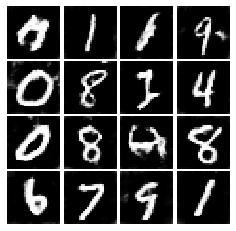

Iter: 1000, D: 0.2129, G:0.4254
Iter: 1050, D: 0.2053, G:0.3867
Iter: 1100, D: 0.1993, G:0.3891
Iter: 1150, D: 0.2167, G:0.4131
Iter: 1200, D: 0.2159, G:0.3889


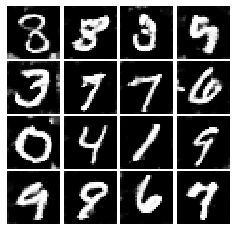

Iter: 1250, D: 0.2107, G:0.4145
Iter: 1300, D: 0.2059, G:0.4212
Iter: 1350, D: 0.1927, G:0.4122
Iter: 1400, D: 0.2074, G:0.4131
Iter: 1450, D: 0.2001, G:0.4559


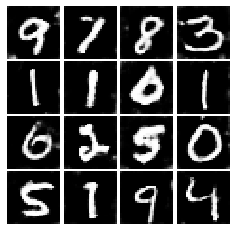

Iter: 1500, D: 0.1981, G:0.4197
Iter: 1550, D: 0.1842, G:0.4357
Iter: 1600, D: 0.1995, G:0.4607
Iter: 1650, D: 0.2024, G:0.4304
Iter: 1700, D: 0.186, G:0.4471


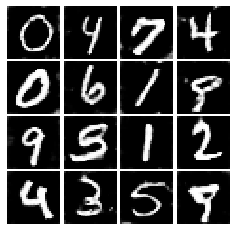

Iter: 1750, D: 0.1939, G:0.4506
Iter: 1800, D: 0.1701, G:0.4841
Iter: 1850, D: 0.1746, G:0.491
Iter: 1900, D: 0.1983, G:0.4668
Iter: 1950, D: 0.1908, G:0.4579


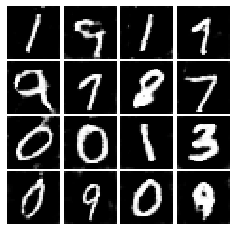

Iter: 2000, D: 0.1915, G:0.4808
Iter: 2050, D: 0.1899, G:0.4551
Iter: 2100, D: 0.1887, G:0.4993
Iter: 2150, D: 0.1655, G:0.5121
Iter: 2200, D: 0.1919, G:0.4917


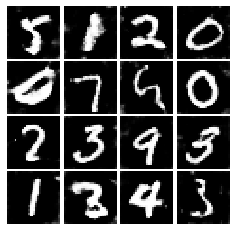

Iter: 2250, D: 0.1845, G:0.5138
Iter: 2300, D: 0.179, G:0.4743
Final images


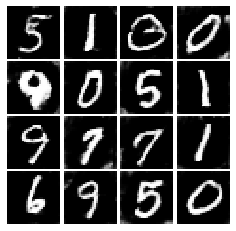

In [0]:
batch_size = 128
epochs = 5
noise_dim = 96

optimizer = Adam(1e-3, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
n_disc_trainable = len(discriminator.trainable_weights)

# Build the generator
generator = build_generator(noise_dim)
n_gen_trainable = len(generator.trainable_weights)

# The generator takes noise as input and generates imgs
gen_inputs = Input(shape=(noise_dim, ))
img = generator(gen_inputs)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='mean_squared_error', optimizer=optimizer)
assert len(discriminator._collected_trainable_weights) == n_disc_trainable
assert len(combined._collected_trainable_weights) == n_gen_trainable

train(X_train, batch_size=batch_size, epochs=epochs)

## WGAN-GP

In [0]:
from keras.layers.merge import _Merge

TRAINING_RATIO = 5  # The training ratio is the number of discriminator updates per generator update. The paper uses 5.
GRADIENT_PENALTY_WEIGHT = 10  # As per the paper


class RandomWeightedAverage(_Merge):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this outputs a random point on the line
    between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could think of.
    Improvements appreciated."""

    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss for a sample batch.
    The Wasserstein loss function is very simple to calculate. In a standard GAN, the discriminator
    has a sigmoid output, representing the probability that samples are real or generated. In Wasserstein
    GANs, however, the output is linear with no activation function! Instead of being constrained to [0, 1],
    the discriminator wants to make the distance between its output for real and generated samples as large as possible.
    The most natural way to achieve this is to label generated samples -1 and real samples 1, instead of the
    0 and 1 used in normal GANs, so that multiplying the outputs by the labels will give you the loss immediately.
    Note that the nature of this loss means that it can be (and frequently will be) less than 0."""
    return K.mean(y_true * y_pred)

def gradient_penalty_loss(y_true, y_pred, averaged_samples, gradient_penalty_weight):
    """Calculates the gradient penalty loss for a batch of "averaged" samples.
    In Improved WGANs, the 1-Lipschitz constraint is enforced by adding a term to the loss function
    that penalizes the network if the gradient norm moves away from 1. However, it is impossible to evaluate
    this function at all points in the input space. The compromise used in the paper is to choose random points
    on the lines between real and generated samples, and check the gradients at these points. Note that it is the
    gradient w.r.t. the input averaged samples, not the weights of the discriminator, that we're penalizing!
    In order to evaluate the gradients, we must first run samples through the generator and evaluate the loss.
    Then we get the gradients of the discriminator w.r.t. the input averaged samples.
    The l2 norm and penalty can then be calculated for this gradient.
    Note that this loss function requires the original averaged samples as input, but Keras only supports passing
    y_true and y_pred to loss functions. To get around this, we make a partial() of the function with the
    averaged_samples argument, and use that for model training."""
    # first get the gradients:
    #   assuming: - that y_pred has dimensions (batch_size, 1)
    #             - averaged_samples has dimensions (batch_size, nbr_features)
    # gradients afterwards has dimension (batch_size, nbr_features), basically
    # a list of nbr_features-dimensional gradient vectors
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)
    
def build_discriminator():
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(64, kernel_size=4, strides=2, padding="valid")(inputs)
    x = LeakyReLU(0.01)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding="valid")(x)
    x = LeakyReLU(0.01)(x)
    x = BatchNormalization()(x, training=True)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.01)(x)
    logits = Dense(1)(x)
    
    model = Model(inputs, logits)
    return model
# build_discriminator()  # 3411649

def build_generator(noise_dim):
    inputs = Input(shape=(noise_dim, ))
    x = Dense(1024, activation="relu")(inputs)
    x = BatchNormalization()(x, training=True)
    x = Dense(7*7*128, activation="relu")(x)
    x = BatchNormalization()(x, training=True)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(64, kernel_size=4, strides=2, activation="relu", padding="same")(x)
    x = BatchNormalization()(x, training=True)
    img = Conv2DTranspose(1, kernel_size=4, strides=2, activation="tanh", padding="same")(x)
    
    model = Model(inputs, img)
    return model
# build_generator(4)  # 6595521

In [0]:
def train(X_train, batch_size=128, epochs=10, show_every=250, print_every=50):
    
    # Adversarial ground truths
    valid = -np.ones((batch_size, 1))
    fake =  np.ones((batch_size, 1))
    dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        
    it = 0
    for epoch in range(epochs):
        for imgs in dataset_batches(X_train).batches(batch_size):
            
            # Sample noise and generate a batch of new images
            z = np.random.uniform(-1, 1, (batch_size, noise_dim))
            d_loss = discriminator_model.train_on_batch([imgs, z], [valid, fake, dummy])
            g_loss = generator_model.train_on_batch(z, valid)
                
            # every show often, show a sample result
            if it % show_every == 0:
                gen_imgs = generator.predict(z)
                fig = show_images(gen_imgs[:16])
                plt.show()

            # Train Discriminator & Generator
            d_loss, g_loss = lsgan_loss(imgs, gen_imgs, z)

            # print loss every so often.
            # We want to make sure D_loss doesn't go to 0
            if it % print_every == 0:
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(it, d_loss[0], g_loss))
                
            it += 1
            
    print('Final images')
    gen_imgs = generator.predict(z)
    fig = show_images(gen_imgs[:16])
    plt.show()

In [0]:
batch_size = 128
epochs = 5
noise_dim = 96

optimizer = Adam(1e-3, 0.5)


# Now we initialize the generator and discriminator.
generator = build_generator()
discriminator = build_discriminator(noise_dim)

# The generator_model is used when we want to train the generator layers.
# As such, we ensure that the discriminator layers are not trainable.
# Note that once we compile this model, updating .trainable will have no effect within it. As such, it
# won't cause problems if we later set discriminator.trainable = True for the discriminator_model, as long
# as we compile the generator_model first.
for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False
generator_input = Input(shape=(noise_dim, ))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)
generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])
# We use the Adam paramaters from Gulrajani et al.
generator_model.compile(optimizer=optimizer, loss=wasserstein_loss)

# Now that the generator_model is compiled, we can make the discriminator layers trainable.
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False

# The discriminator_model is more complex. It takes both real image samples and random noise seeds as input.
# The noise seed is run through the generator model to get generated images. Both real and generated images
# are then run through the discriminator. Although we could concatenate the real and generated images into a
# single tensor, we don't (see model compilation for why).
real_samples = Input(shape=(28, 28, 1))
generator_input_for_discriminator = Input(shape=(noise_dim, ))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

# We also need to generate weighted-averages of real and generated samples, to use for the gradient norm penalty.
averaged_samples = RandomWeightedAverage()([real_samples, generated_samples_for_discriminator])
# We then run these samples through the discriminator as well. Note that we never really use the discriminator
# output for these samples - we're only running them to get the gradient norm for the gradient penalty loss.
averaged_samples_out = discriminator(averaged_samples)

# The gradient penalty loss function requires the input averaged samples to get gradients. However,
# Keras loss functions can only have two arguments, y_true and y_pred. We get around this by making a partial()
# of the function with the averaged samples here.
partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gradient_penalty'  # Functions need names or Keras will throw an error

# Keras requires that inputs and outputs have the same number of samples. This is why we didn't concatenate the
# real samples and generated samples before passing them to the discriminator: If we had, it would create an
# output with 2 * BATCH_SIZE samples, while the output of the "averaged" samples for gradient penalty
# would have only BATCH_SIZE samples.

# If we don't concatenate the real and generated samples, however, we get three outputs: One of the generated
# samples, one of the real samples, and one of the averaged samples, all of size BATCH_SIZE. This works neatly!
discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator],
                            outputs=[discriminator_output_from_real_samples,
                                     discriminator_output_from_generator,
                                     averaged_samples_out])
# We use the Adam paramaters from Gulrajani et al. We use the Wasserstein loss for both the real and generated
# samples, and the gradient penalty loss for the averaged samples.
discriminator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),
                            loss=[wasserstein_loss,
                                  wasserstein_loss,
                                  partial_gp_loss])
# We make three label vectors for training. positive_y is the label vector for real samples, with value 1.
# negative_y is the label vector for generated samples, with value -1. The dummy_y vector is passed to the
# gradient_penalty loss function and is not used.
# positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
# negative_y = -positive_y
# dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32)

In [0]:
batch_size = 128
epochs = 5
noise_dim = 96

optimizer = Adam(1e-3, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
n_disc_trainable = len(discriminator.trainable_weights)

# Build the generator
generator = build_generator(noise_dim)
n_gen_trainable = len(generator.trainable_weights)

# The generator takes noise as input and generates imgs
gen_inputs = Input(shape=(noise_dim, ))
img = generator(gen_inputs)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='mean_squared_error', optimizer=optimizer)
assert len(discriminator._collected_trainable_weights) == n_disc_trainable
assert len(combined._collected_trainable_weights) == n_gen_trainable

train(X_train, batch_size=batch_size, epochs=epochs)

## Adversarial autoencoder

In [0]:
# from keras.datasets import mnist
# from keras.layers import Input, Dense, Reshape, Flatten, Lambda
# from keras.layers.advanced_activations import LeakyReLU
# from keras.models import Model
# from keras.optimizers import Adam
# import keras.backend as K

In [0]:
class AdversarialAutoencoder():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 10

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the encoder / decoder
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=self.img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        encoded_repr = self.encoder(img)
        reconstructed_img = self.decoder(encoded_repr)

        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator determines validity of the encoding
        validity = self.discriminator(encoded_repr)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)


    def build_encoder(self):
        def sampling(args):
            """Reparameterization trick by sampling fr an isotropic unit Gaussian.
            # Arguments:
                args (tensor): mean and log of variance of Q(z|X)
            # Returns:
                z (tensor): sampled latent vector
            """
            mu, log_var = args
            batch_size = K.shape(mu)[0]
            latent_dim = K.int_shape(mu)[1]
            epsilon = K.random_normal(shape=(batch_size, latent_dim))
            return mu + K.exp(0.5 * log_var) * epsilon
    
        # Encoder
        img = Input(shape=self.img_shape)
        h = Flatten()(img)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        mu = Dense(self.latent_dim)(h)
        log_var = Dense(self.latent_dim)(h)
        latent_repr = Lambda(sampling, output_shape=(self.latent_dim,))([mu, log_var])
        model = Model(img, latent_repr)
        print(model.summary())
        return model

    def build_decoder(self):
        # Decoder
        z = Input(shape=(self.latent_dim,))
        h = Dense(512)(z)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dense(np.prod(self.img_shape), activation='tanh')(h)
        img = Reshape(self.img_shape)(h)
        model = Model(z, img)
        print(model.summary())
        return model

    def build_discriminator(self):
        # Discriminator
        encoded_repr = Input(shape=(self.latent_dim, ))
        h = Dense(512)(encoded_repr)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dense(256)(h)
        h = LeakyReLU(alpha=0.2)(h)
        validity = Dense(1, activation="sigmoid")(h)
        model = Model(encoded_repr, validity)
        print(model.summary())
        return model

    def train(self, epochs, batch_size=128, sample_interval=50):
        # Load the dataset
        (X_train, _), (_, _) = load_mnist_data(dim=3)

        # Rescale -1 to 1
        X_train = rescale_image(X_train, True) #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            latent_fake = self.encoder.predict(imgs)
            latent_real = np.random.normal(size=(batch_size, self.latent_dim))

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(latent_real, valid)
            d_loss_fake = self.discriminator.train_on_batch(latent_fake, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                print("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5

        z = np.random.normal(size=(r*c, self.latent_dim))
        gen_imgs = self.decoder.predict(z)
        gen_imgs = rescale_image(gen_imgs, False) #gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/mnist_%d.png" % epoch)
        #plt.close()
        plt.show()


aae = AdversarialAutoencoder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 10)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
None

60000 train samples
10000 test samples
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.713804, acc: 35.94%] [G loss: 0.964946, mse: 0.965207]


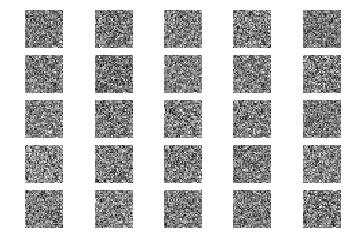

200 [D loss: 0.111005, acc: 98.44%] [G loss: 0.129530, mse: 0.124497]


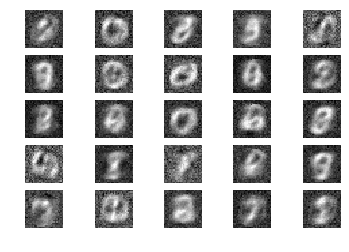

400 [D loss: 0.021749, acc: 100.00%] [G loss: 0.124029, mse: 0.117647]


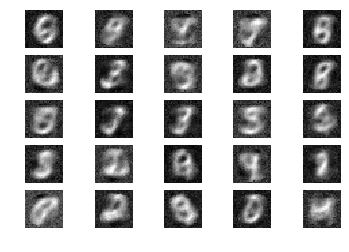

600 [D loss: 0.021089, acc: 100.00%] [G loss: 0.111169, mse: 0.104983]


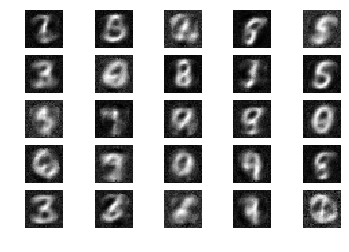

800 [D loss: 0.099480, acc: 96.88%] [G loss: 0.117227, mse: 0.110687]


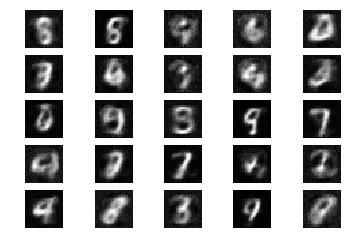

In [0]:
aae.train(epochs=1000, batch_size=32, sample_interval=200)

In [0]:
def save(model, model_name):
    model_path = "models/%s.json" % model_name
    weights_path = "models/%s_weights.hdf5" % model_name
    json_string = model.to_json()
    open(model_path, 'w').write(json_string)
    model.save_weights(weights_path)

save(aae.adversarial_autoencoder, "aae_adversarial_autoencoder")
save(aae.discriminator, "aae_discriminator")

## CycleGAN

In [0]:
import os
import sys
import scipy
import datetime
from data_loader import DataLoader

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [0]:
class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'apple2orange'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                if batch_i % sample_interval == 0:
                    print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                          % (epoch, epochs, batch_i, self.data_loader.n_batches,
                             d_loss[0], 100*d_loss[1], g_loss[0],
                             np.mean(g_loss[1:3]), np.mean(g_loss[3:5]), np.mean(g_loss[5:6]),
                             elapsed_time))

                # If at save interval => save generated image samples
                
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('datasets/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('datasets/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()    

In [0]:
gan = CycleGAN()
gan.train(epochs=200, batch_size=1, sample_interval=200)

/home/kokmeng/anaconda3/envs/tf19/lib/python3.5/site-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/200] [Batch 0/995] [D loss: 11.770045, acc:  13%] [G loss: 366.681671, adv: 176.015152, recon: 0.666499, id: 0.826716] time: 0:00:42.733770 
[Epoch 0/200] [Batch 200/995] [D loss: 0.474909, acc:   5%] [G loss: 5.719319, adv: 0.381665, recon: 0.223683, id: 0.236196] time: 0:11:42.026305 
[Epoch 0/200] [Batch 400/995] [D loss: 0.245729, acc:  57%] [G loss: 4.348593, adv: 0.420661, recon: 0.152382, id: 0.249024] time: 0:22:07.115026 
[Epoch 0/200] [Batch 600/995] [D loss: 0.168599, acc:  88%] [G loss: 4.264268, adv: 0.503167, recon: 0.146416, id: 0.084351] time: 0:32:47.531737 
[Epoch 0/200] [Batch 800/995] [D loss: 0.272610, acc:  54%] [G loss: 3.461635, adv: 0.370147, recon: 0.117315, id: 0.191852] time: 0:43:24.722365 
[Epoch 1/200] [Batch 0/995] [D loss: 0.279602, acc:  43%] [G loss: 3.265220, adv: 0.362046, recon: 0.109832, id: 0.129426] time: 0:53:33.174135 
[Epoch 1/200] [Batch 200/995] [D loss: 0.257418, acc:  49%] [G loss: 2.419826, adv: 0.330135, recon: 0.072547, id: 0.

[Epoch 11/200] [Batch 200/995] [D loss: 0.284328, acc:  39%] [G loss: 1.898224, adv: 0.279645, recon: 0.054554, id: 0.086198] time: 6:45:59.090222 
[Epoch 11/200] [Batch 400/995] [D loss: 0.169511, acc:  98%] [G loss: 2.919123, adv: 0.384579, recon: 0.090971, id: 0.206182] time: 6:51:54.275307 
[Epoch 11/200] [Batch 600/995] [D loss: 0.245680, acc:  54%] [G loss: 2.835688, adv: 0.354406, recon: 0.089688, id: 0.195159] time: 6:57:49.262556 
[Epoch 11/200] [Batch 800/995] [D loss: 0.333431, acc:  27%] [G loss: 2.641311, adv: 0.325618, recon: 0.082129, id: 0.077483] time: 7:03:43.988316 
[Epoch 12/200] [Batch 0/995] [D loss: 0.129718, acc:  99%] [G loss: 2.595837, adv: 0.471884, recon: 0.072167, id: 0.048293] time: 7:09:27.753670 
[Epoch 12/200] [Batch 200/995] [D loss: 0.198123, acc:  77%] [G loss: 2.341278, adv: 0.415436, recon: 0.066214, id: 0.051452] time: 7:15:21.493365 
[Epoch 12/200] [Batch 400/995] [D loss: 0.274514, acc:  50%] [G loss: 2.140802, adv: 0.333286, recon: 0.058815, id

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 18/200] [Batch 400/995] [D loss: 0.372260, acc:  17%] [G loss: 1.905602, adv: 0.232014, recon: 0.059305, id: 0.191316] time: 10:17:49.128495 
[Epoch 18/200] [Batch 600/995] [D loss: 0.250922, acc:  55%] [G loss: 1.939375, adv: 0.349536, recon: 0.050967, id: 0.062397] time: 10:23:43.830018 
[Epoch 18/200] [Batch 800/995] [D loss: 0.339414, acc:  23%] [G loss: 1.775069, adv: 0.322769, recon: 0.049773, id: 0.060763] time: 10:29:38.907233 
[Epoch 19/200] [Batch 0/995] [D loss: 0.138292, acc:  93%] [G loss: 2.567958, adv: 0.498546, recon: 0.066158, id: 0.149646] time: 10:35:24.760302 
[Epoch 19/200] [Batch 200/995] [D loss: 0.163492, acc:  89%] [G loss: 2.239868, adv: 0.401727, recon: 0.059303, id: 0.111621] time: 10:41:21.780051 
[Epoch 19/200] [Batch 400/995] [D loss: 0.218915, acc:  71%] [G loss: 2.139058, adv: 0.355023, recon: 0.059884, id: 0.184102] time: 10:47:16.750027 
[Epoch 19/200] [Batch 600/995] [D loss: 0.195524, acc:  73%] [G loss: 1.947673, adv: 0.355758, recon: 0.0553

KeyboardInterrupt: 